# **Teamfight Tactics: Clustering Analysis of in-game strategies**
--- 
- Teamfight Tactics is a round-base autobattler by Riot Games.
- This dataset contains the last 75 Teamfight Tactics matches played by the top 100 Challenger Players in NA, and 4 dictionaries containing the Augment, item, and traits data. 
- Data was derived from Riot API and dowloaded from Kaggle https://www.kaggle.com/datasets/cmsc320tftproject/cmsc320-tft-challenger-dataset-set-65
- This notebook mainly contains codes for analysis, the analysis outcome are presented as Tableau dashboards https://public.tableau.com/app/profile/xinyu.xiang5112/viz/TeamfightTacticscomboanalysis/traitsStats 

## **Aim**
- To understand players' in-game startegies and the most likely winning combinations of units, traits, and items in the game. 
- To identify most used items per combos and the best holders of each item (by average placement).
- To understand the trait composition of each combo and the trait level composition of each trait. 

## **Terminology**
- **Champions**: 
   - Units in the Teamfight Tactics game mode that fight in arenas to protect the Little Legend
- **Augment** 
   - Permanent bonuses that are added to the player's hexcore.
- **Trait**: 
   - A core mechanic that groups champions by shared characteristics to provide powerful bonuses, with effects scaling as you field more units of that trait..
- **Item**: 
   - A modular enhancement that grants bonuses and capabilities beyond what Champions and units have access to by default.
- **Combo**: 
   - A combination of units, items, and traits that can be used to build a powerful team.

## **Key Metrics**
- **Average placement**
   - the average placement (of the combo/item/unit/trait) which the player achieved. 
- **Pick rate**: 
   - the percentage of games (of the combo/item/unit/trait) where the player was played. 
- **Top 4 rate**: 
   - the percentage of games (of the combo/item/unit/trait) where the player ended up in the top 4 placements.
- **Win rate**: 
   - the percentage of games (of the combo/item/unit/trait) where the player won / ended up in the top 1 placement.


## **Analysis Plan**
- **Data cleaning and preprocessing** 
  - Handle nested columns
  - Load dictionaries into dataframe
- **Descriptive analysis** 
  - Trait performance by average placement, top4 and win rate 
  - Champion performance by average placement, top4 and win rate 
  - Item performance by average placement, top4 and win rate
  - Augment performance by average placement, top4 and win rate 
- **Identifying combos - Unsupervised learning: kMeans clustering of Traits** 
  - Identify clusters and fit model 
  - Cluster Characteristics 
    - Cluster distribution plot 
    - PCA cluster plot 
- **Cluster analysis** 
  - **Cluster descriptive analysis** 
    - Cluster performance by average placement, top4 and win rate
    - Cluster placement distribution 
  - **Trait usage by clusters**
    - Heatmap of traits by clusters 
    - Trait performance by clusters 
    - Trait level performance by clusters 
  - **Augment usage by clusters**
    - Top4 rate of single augment per cluster
    - Top4 rate of augment category per cluster
    - Top4 rate of pair-wise augment combo per cluster 
  - **Champion/Unit usage by clusters** 
    - Top-10 most frequent champions per cluster 
    - Unit performance (average placement, top4 & win rate) by clusters
  - **Item usage by clusters** 
    - Top 5 most used item per champion per cluster
    - Item performance (average place & play rate) by clusters 
    - Best item holders (by average placement) per item per cluster 
    - Best item (by top4 rate) per champion per cluster 
    - Top-10 champions per cluster with best items (by top4 rate)

In [1]:
import ast
import pandas as pd 
import json 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Data cleaning and preprocessing

In [3]:
tft_match = pd.read_csv('C:/Users/08042/Desktop/projects/RIOT TFT/data/TFTdataset.csv')
tft_match.head()

,augments,level,placement,traits,units,Match ID
0,"['DebonairTrait', 'Distancing2', 'DebonairEmbl...",7,8,"[{'name': 'Assassin', 'num_units': 2, 'style':...","[{'character_id': 'Talon', 'items': [69, 19, 2...",NA1_4247681350
1,"['AssassinCutthroat', 'RichGetRicher', 'Divers...",9,3,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
2,"['EnchanterTrait', 'SunfireBoard', 'TwinshotTr...",8,2,"[{'name': 'Bruiser', 'num_units': 2, 'style': ...","[{'character_id': 'Sejuani', 'items': [], 'nam...",NA1_4247681350
3,"['CalculatedLoss', 'ExperimentalEmblem', 'Arca...",9,1,"[{'name': 'Arcanist', 'num_units': 4, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
4,"['Phalanx1', 'ArcanistSpellBlade', 'Experiment...",9,4,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'RekSai', 'items': [], 'name...",NA1_4247681350


In [4]:
# parse nested columns (augments, traits, units)

nested_cols = ['augments', 'traits', 'units']

for col in nested_cols:
   tft_match[col] = tft_match[col].apply(ast.literal_eval)

tft_match.head()


,augments,level,placement,traits,units,Match ID
0,"[DebonairTrait, Distancing2, DebonairEmblem2]",7,8,"[{'name': 'Assassin', 'num_units': 2, 'style':...","[{'character_id': 'Talon', 'items': [69, 19, 2...",NA1_4247681350
1,"[AssassinCutthroat, RichGetRicher, Diversify3]",9,3,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
2,"[EnchanterTrait, SunfireBoard, TwinshotTrait2]",8,2,"[{'name': 'Bruiser', 'num_units': 2, 'style': ...","[{'character_id': 'Sejuani', 'items': [], 'nam...",NA1_4247681350
3,"[CalculatedLoss, ExperimentalEmblem, ArcanistE...",9,1,"[{'name': 'Arcanist', 'num_units': 4, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
4,"[Phalanx1, ArcanistSpellBlade, ExperimentalEmb...",9,4,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'RekSai', 'items': [], 'name...",NA1_4247681350


In [5]:
# Quick peek at structure of one row
sample_row = tft_match.iloc[0]
print('Augments:', sample_row['augments'])
print('Traits:', sample_row['traits'][:3])   # first 3
print('Units:', sample_row['units'][:3])     # first 3


Augments: ['DebonairTrait', 'Distancing2', 'DebonairEmblem2']
Traits: [{'name': 'Assassin', 'num_units': 2, 'style': 1, 'tier_current': 1, 'tier_total': 3}, {'name': 'Bodyguard', 'num_units': 2, 'style': 1, 'tier_current': 1, 'tier_total': 4}, {'name': 'Challenger', 'num_units': 1, 'style': 0, 'tier_current': 0, 'tier_total': 4}]
Units: [{'character_id': 'Talon', 'items': [69, 19, 22], 'name': '', 'rarity': 1, 'tier': 2}, {'character_id': 'Zyra', 'items': [70], 'name': '', 'rarity': 1, 'tier': 2}, {'character_id': 'Blitzcrank', 'items': [70], 'name': '', 'rarity': 1, 'tier': 2}]


Number of rows: 40000
              level     placement
count  40000.000000  40000.000000
mean       8.128025      4.500000
std        0.686146      2.291316
min        3.000000      1.000000
25%        8.000000      2.750000
50%        8.000000      4.500000
75%        9.000000      6.250000
max       10.000000      8.000000


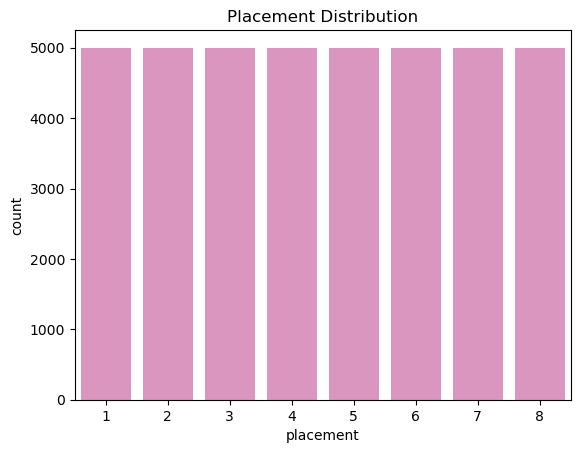

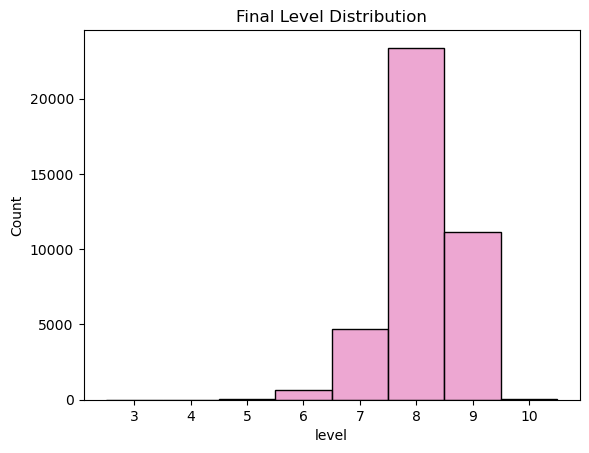

In [6]:
# quick EDA

print('Number of rows:', len(tft_match))
print(tft_match[['level', 'placement']].describe())

plt.figure()
sns.countplot(x='placement', data=tft_match,color='#e78ac3')
plt.title('Placement Distribution')
plt.show()

plt.figure()
sns.histplot(tft_match['level'], bins=range(3, 10), discrete=True,color='#e78ac3')
plt.title('Final Level Distribution')
plt.show()


In [7]:
# load dictionaries
with open('C:/Users/08042/Desktop/projects/RIOT TFT/data/TFTAugmentDictionary.json', 'r') as f:
    augment_tier = ast.literal_eval(f.read())

with open('C:/Users/08042/Desktop/projects/RIOT TFT/data/TFTAugmentNamesDict.json', 'r') as f:
    augment_names = json.load(f)

with open('C:/Users/08042/Desktop/projects/RIOT TFT/data/TFTitemDictionary.json', 'r') as f:
    item_dict = ast.literal_eval(f.read())

with open('C:/Users/08042/Desktop/projects/RIOT TFT/data/TFTTraitDictionary.json', 'r') as f:
    trait_dict = ast.literal_eval(f.read())

In [8]:
print(augment_tier)
print(augment_names)
print(trait_dict)
print(item_dict)

{'ArcanistEmblem': 'Gold', 'ArcanistEmblem2': 'Prismatic', 'ArcanistRunicShield1': 'Silver', 'ArcanistRunicShield2': 'Gold', 'ArcanistSpellBlade': 'Gold', 'ArcanistTrait': 'Silver', 'Archangel2': 'Gold', 'Ascension': 'Silver', 'AssassinCutthroat': 'Silver', 'AssassinEmblem': 'Gold', 'AssassinEmblem2': 'Prismatic', 'AssassinSmokeBomb': 'Gold', 'AssassinTrait': 'Silver', 'Backfoot1': 'Silver', 'Backfoot2': 'Gold', 'Backfoot3': 'Prismatic', 'BandOfThieves1': 'Prismatic', 'Battlemage1': 'Silver', 'Battlemage2': 'Gold', 'Battlemage3': 'Prismatic', 'BinaryAirdrop': 'Gold', 'BlueBattery1': 'Silver', 'BlueBattery2': 'Prismatic', 'BrawlerHPRegen1': 'Silver', 'BruteEmblem': 'Gold', 'BruteEmblem2': 'Prismatic', 'BruteTrait': 'Silver', 'CalculatedLoss': 'Silver', 'CelestialBlessing1': 'Silver', 'CelestialBlessing2': 'Gold', 'CelestialBlessing3': 'Prismatic', 'ChallengerEmblem': 'Gold', 'ChallengerEmblem2': 'Prismatic', 'ChallengerEnGarde': 'Silver', 'ChallengerForAllUnits': 'Silver', 'ChallengerTr

# 2. Descriptive Analysis

### 2.1 Trait analysis

In [169]:
traits_expanded = (
    tft_match[['Match ID', 'placement', 'traits']]
    .explode('traits')
    .dropna(subset=['traits'])
    .reset_index(drop=True)
)

# Each 'traits' entry is a dict: {'name': 'Arcanist', 'num_units': 4, 'style': 2}
traits_expanded['trait_name'] = traits_expanded['traits'].apply(lambda t: t.get('name'))
traits_expanded['trait_num_units'] = traits_expanded['traits'].apply(lambda t: t.get('num_units'))
traits_expanded['trait_style'] = traits_expanded['traits'].apply(lambda t: t.get('style'))

traits_expanded.head()
# print(traits_expanded.shape[0])

,Match ID,placement,traits,trait_name,trait_num_units,trait_style
0,NA1_4247681350,8,"{'name': 'Assassin', 'num_units': 2, 'style': ...",Assassin,2,1
1,NA1_4247681350,8,"{'name': 'Bodyguard', 'num_units': 2, 'style':...",Bodyguard,2,1
2,NA1_4247681350,8,"{'name': 'Challenger', 'num_units': 1, 'style'...",Challenger,1,0
3,NA1_4247681350,8,"{'name': 'Debonair', 'num_units': 7, 'style': ...",Debonair,7,4
4,NA1_4247681350,8,"{'name': 'Innovator', 'num_units': 1, 'style':...",Innovator,1,0


#### Trait performance (top4 rate, win rate)

In [ ]:
# trait performance 
def top4_rate(x):
    return (x <= 4).mean()

def win_rate(x):
    return (x == 1).mean()

trait_perf = (
    traits_expanded
    .groupby('trait_name')['placement']
    .agg(avg_placement = 'mean',
         top4_rate=top4_rate, 
         win_rate=win_rate, 
         games='count')
    .sort_values('top4_rate', ascending=False)
)

trait_perf.to_csv('trait_perf.csv')


In [216]:
# trait level performance 
trait_level_perf = (
    traits_expanded
    .groupby(['trait_name','trait_style'])['placement']
    .agg(avg_placement = 'mean',
         top4_rate=top4_rate, 
         win_rate=win_rate, 
         games='count')
    .sort_values(['trait_name','trait_style'], ascending=True)
).reset_index()
trait_level_perf = trait_level_perf[trait_level_perf['trait_style']>0]
trait_level_perf['level_freq'] = trait_level_perf.groupby('trait_name')['games'].transform(lambda x: x/x.sum())


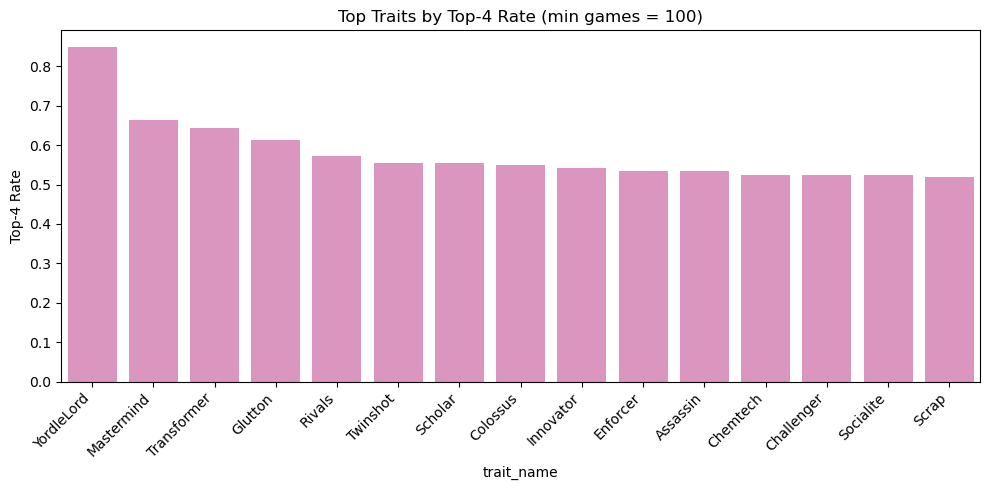

In [11]:
min_games = 100  # adjust depending on dataset size

top_traits = trait_perf[trait_perf['games'] >= min_games].sort_values('top4_rate', ascending=False).head(15)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_traits.index, y=top_traits['top4_rate'],color='#e78ac3')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Top-4 Rate')
plt.title('Top Traits by Top-4 Rate (min games = {})'.format(min_games))
plt.tight_layout()
plt.show()


### 2.2 Units/Champion analysis

In [12]:
# 4.1 EXPLODE UNITS

units_expanded = (
    tft_match[['Match ID', 'placement', 'units']]
    .explode('units')
    .dropna(subset=['units'])
    .reset_index(drop=True)
)

# Each 'units' entry is dict: {'character_id': 'Talon', 'items': [69, 19, 20], 'name':'Talon', 'rarity':1, 'tier':2}
units_expanded['champ_name'] = units_expanded['units'].apply(lambda u: u.get('name'))
units_expanded['champ_id'] = units_expanded['units'].apply(lambda u: u.get('character_id'))
units_expanded['champ_tier'] = units_expanded['units'].apply(lambda u: u.get('tier'))
units_expanded['champ_rarity'] = units_expanded['units'].apply(lambda u: u.get('rarity'))
units_expanded['items'] = units_expanded['units'].apply(lambda u: u.get('items', []))

units_expanded.head()


,Match ID,placement,units,champ_name,champ_id,champ_tier,champ_rarity,items
0,NA1_4247681350,8,"{'character_id': 'Talon', 'items': [69, 19, 22...",,Talon,2,1,"[69, 19, 22]"
1,NA1_4247681350,8,"{'character_id': 'Zyra', 'items': [70], 'name'...",,Zyra,2,1,[70]
2,NA1_4247681350,8,"{'character_id': 'Blitzcrank', 'items': [70], ...",,Blitzcrank,2,1,[70]
3,NA1_4247681350,8,"{'character_id': 'Syndra', 'items': [], 'name'...",,Syndra,2,1,[]
4,NA1_4247681350,8,"{'character_id': 'Leona', 'items': [], 'name':...",,Leona,1,2,[]


#### Champion performance (top4 rate, win rate)

In [13]:
champ_perf = (
    units_expanded
    .groupby('champ_id')['placement']
    .agg(avg_placement = 'mean',
         top4_rate=top4_rate, 
         win_rate=win_rate, 
         games='count')
    .sort_values('top4_rate', ascending=False)
)

champ_perf.head(20)

,avg_placement,top4_rate,win_rate,games
champ_id,,,,
Veigar,2.518797,0.857143,0.300752,133
Galio,3.602740,0.676125,0.212329,2044
Silco,3.619860,0.664995,0.200875,10967
Jinx,3.675824,0.647996,0.211678,8409
Jayce,3.700886,0.644955,0.205546,8582
Kaisa,3.739386,0.640540,0.208578,4593
Viktor,3.779448,0.632754,0.188148,6851
TahmKench,3.881136,0.613504,0.211209,5317
Zeri,4.007961,0.592290,0.170962,4773


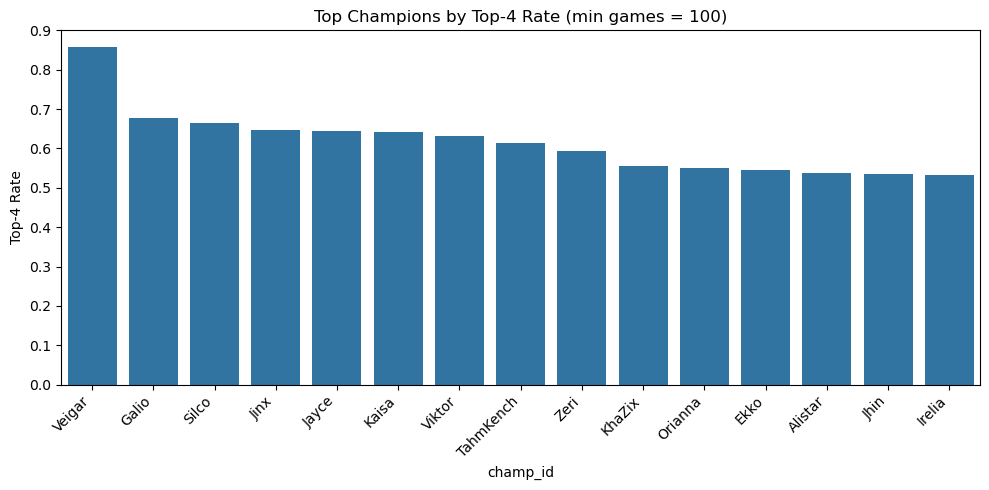

In [14]:
# plot top champions by top-4 rate
min_games = 100  # adjust depending on dataset size
top_champs = champ_perf[champ_perf['games'] >= min_games].sort_values('top4_rate', ascending=False).head(15)    
plt.figure(figsize=(10, 5))
sns.barplot(x=top_champs.index, y=top_champs['top4_rate'])
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Top-4 Rate')
plt.title('Top Champions by Top-4 Rate (min games = {})'.format(min_games))
plt.tight_layout()  
plt.show()

In [116]:
# create the champion tooltip table for tableau 
champion_info = pd.read_csv('champions.csv')

champion_info = champion_info.rename(columns={
    "Name": "champ_name",
    "Synergies": "traits",
    "Ability Description": "ability_desc",
    "Ability": "ability_name"
})

rows = []

for _, r in champion_info.iterrows():
    champ = r["champ_name"]

    # --------------------
    # 1. Header
    # --------------------
    rows.append({
        "champ_name": champ,
        "section_order": 1,
        "row_order": 1,
        "section": "header",
        "text": champ
    })

    # --------------------
    # 2. Traits
    # --------------------
    rows.append({
        "champ_name": champ,
        "section_order": 2,
        "row_order": 1,
        "section": "traits_header",
        "text": "Traits"
    })

    traits = r["traits"]  # assume list OR comma-separated string
    if isinstance(traits, str):
        traits = [t.strip() for t in traits.split(",")]

    for i, trait in enumerate(traits, start=2):
        rows.append({
            "champ_name": champ,
            "section_order": 2,
            "row_order": i,
            "section": "trait",
            "text": trait
        })

    # --------------------
    # 3. Ability
    # --------------------
    rows.append({
        "champ_name": champ,
        "section_order": 3,
        "row_order": 1,
        "section": "Ability",
        "text": r["ability_name"]
    })

    rows.append({
        "champ_name": champ,
        "section_order": 3,
        "row_order": 3,
        "section": "Ability Description",
        "text": r["ability_desc"]
    })

    # --------------------
    # 4. Stats (one per row)
    # --------------------

    stats = {
        "HP": r["Health"],
        "Armor": r["Armor"],
        "MR": r["MR"],
        "AS": r["Atk Spd"],
        "DPS": r["DPS"],
        "Range": r["Range"],
        "Crit Rate": r["Crit Rate"],
        "Ability Power": r["Ability Power"]
    }

    for i, (k, v) in enumerate(stats.items(), start=2):
        rows.append({
            "champ_name": champ,
            "section_order": 4,
            "row_order": i,
            "section": "Stats",
            "text": f"{k}: {v}"
        })

tooltip_df = pd.DataFrame(rows)


tooltip_df.head(50)
tooltip_df.to_csv('tooltip_df.csv', index=False)

In [117]:
tooltip_df.head(50)

,champ_name,section_order,row_order,section,text
0,Aatrox,1,1,header,Aatrox
1,Aatrox,2,1,traits_header,Traits
2,Aatrox,2,2,trait,Ghostly
3,Aatrox,2,3,trait,Inkshadow
4,Aatrox,2,4,trait,Bruiser
5,Aatrox,3,1,Ability,Phantom Blade
6,Aatrox,3,3,Ability Description,20% Shred the current target for 4 seconds and...
7,Aatrox,4,2,Stats,HP: 700 / 1260 / 2268
8,Aatrox,4,3,Stats,Armor: 45
9,Aatrox,4,4,Stats,MR: 45


In [125]:
ability_df = tooltip_df[tooltip_df['section'].isin(['Ability', 'Ability Description'])].copy()

ability_df['category'] = ability_df['section'].map({
    'Ability': 'Ability',
    'Ability Description': 'Ability des'
})

ability_df['value'] = ability_df['text']

ability_df = ability_df[['champ_name', 'category', 'value']]

stats_df = tooltip_df[tooltip_df['section'] == 'Stats'].copy()

# split on first colon only
stats_df[['category', 'value']] = (
    stats_df['text']
    .str.split(':', n=1, expand=True)
)

stats_df['category'] = stats_df['category'].str.strip()
stats_df['value'] = stats_df['value'].str.strip()

stats_df = stats_df[['champ_name', 'category', 'value']]

tooltip_table = pd.concat(
    [ability_df, stats_df],
    ignore_index=True
)

order_map = {
    'Ability': 1,
    'Ability des': 2,
    'HP': 3,
    'Armor': 4,
    'MR': 5,
    'AS': 6,
    'DPS': 7,
    'Range': 8,
    'Crit Rate': 9,
    'Ability Power': 10
}
tooltip_table['display_order'] = tooltip_table['category'].map(order_map)
tooltip_table = tooltip_table.sort_values(
    ['champ_name', 'display_order'],
    ascending=[True, True]
).reset_index(drop=True)

tooltip_table.to_csv('tooltip_table.csv', index=False)

### 2.3 Item analysis 

In [16]:
# flatten items to one row per (match, unit, item_id)

item_rows = []

for _, row in units_expanded.iterrows():
    match_id = row['Match ID']
    placement = row['placement']
    champ = row['champ_id']
    for item_id in row['items']:
        item_rows.append({'Match ID': match_id,
                     'placement': placement,
                     'champ_name': champ,
                     'item_id': item_id})

items_expanded = pd.DataFrame(item_rows)
items_expanded.head()

# map item_id to item_name
items_expanded['item_id_str'] = items_expanded['item_id'].astype(str)
items_expanded['item_name'] = items_expanded['item_id_str'].map(item_dict)

items_expanded.head()

,Match ID,placement,champ_name,item_id,item_id_str,item_name
0,NA1_4247681350,8,Talon,69,69,Quicksilver
1,NA1_4247681350,8,Talon,19,19,Infinity Edge
2,NA1_4247681350,8,Talon,22,22,Rapid Firecannon
3,NA1_4247681350,8,Zyra,70,70,Debonair Emblem
4,NA1_4247681350,8,Blitzcrank,70,70,Debonair Emblem


In [17]:
# Aggregate item performance across all champions
item_perf = (
    items_expanded
    .groupby('item_name')['placement']
    .agg(
        avg_placement = 'mean',
        top4_rate     = top4_rate,
        win_rate      = win_rate,
        games         = 'count'
    )
    .sort_values('top4_rate', ascending=False)
)

item_perf.head(20)


,avg_placement,top4_rate,win_rate,games
item_name,,,,
Brink of Dawn,2.263158,0.947368,0.421053,19
Statikk's Favor,3.423077,0.730769,0.346154,26
Rascal's Gloves,3.144928,0.710145,0.318841,69
Dvarapala Stoneplate,3.968750,0.687500,0.125000,32
Covalent Spark,4.080000,0.680000,0.120000,25
Innovator Emblem,3.611529,0.675439,0.229323,798
Tactician's Crown,3.494647,0.674518,0.270878,934
Urf-Angel's Staff,3.750000,0.666667,0.083333,12
Clockwork Emblem,3.714511,0.656151,0.212934,634


#### Item performance (top4 rate, win rate)

In [18]:
min_games = 100   # adjust based on dataset size

item_perf_filtered = item_perf[item_perf['games'] >= min_games].copy()
item_perf_filtered.head(20)


,avg_placement,top4_rate,win_rate,games
item_name,,,,
Innovator Emblem,3.611529,0.675439,0.229323,798
Tactician's Crown,3.494647,0.674518,0.270878,934
Clockwork Emblem,3.714511,0.656151,0.212934,634
Assassin Emblem,3.793227,0.633658,0.178040,1949
Infinity Force,3.805556,0.632937,0.178571,504
Archangel's Staff,3.799199,0.630975,0.173031,3745
Mutant Emblem,3.804109,0.628285,0.211180,2093
Edge of Night,3.799545,0.627843,0.194120,6156
Enforcer Emblem,3.821159,0.627204,0.198992,397


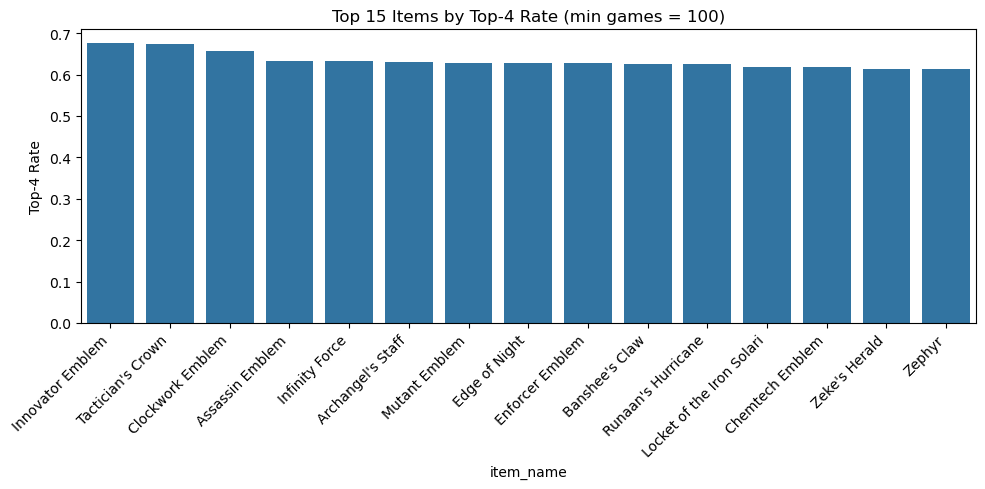

In [19]:
top_n = 15

top_items = (
    item_perf_filtered
    .sort_values('top4_rate', ascending=False)
    .head(top_n)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_items.index,
    y=top_items['top4_rate']
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Top-4 Rate')
plt.title(f'Top {top_n} Items by Top-4 Rate (min games = {min_games})')
plt.tight_layout()
plt.show()


In [20]:
# Group by (item, champion)
item_champ_perf = (
    items_expanded
    .groupby(['item_name', 'champ_name'])['placement']
    .agg(
        avg_placement = 'mean',
        top4_rate     = top4_rate,
        win_rate      = win_rate,
        games         = 'count'
    )
    .reset_index()
)

item_champ_perf.head(20)


,item_name,champ_name,avg_placement,top4_rate,win_rate,games
0,Anima Visage,Ahri,8.000000,0.000000,0.000000,1
1,Anima Visage,Alistar,4.447368,0.605263,0.078947,38
2,Anima Visage,Blitzcrank,5.000000,0.000000,0.000000,2
3,Anima Visage,Braum,5.227273,0.409091,0.090909,22
4,Anima Visage,Camille,4.666667,0.666667,0.000000,3
5,Anima Visage,ChoGath,3.794118,0.647059,0.147059,34
6,Anima Visage,Darius,7.000000,0.000000,0.000000,2
7,Anima Visage,Galio,3.900000,0.500000,0.400000,10
8,Anima Visage,Gnar,5.250000,0.500000,0.000000,4
9,Anima Visage,Illaoi,7.500000,0.000000,0.000000,2


#### Item-champion combo performance (average placement, top4 rate, win rate)

In [21]:
min_pair_games = 50 
strong_pairs = (
    item_champ_perf[item_champ_perf['games'] >= min_pair_games]
    .sort_values('top4_rate', ascending=False)
    .head(30)
)

strong_pairs


,item_name,champ_name,avg_placement,top4_rate,win_rate,games
2257,Locket of the Iron Solari,Silco,2.862069,0.827586,0.241379,58
1072,Debonair Emblem,Viktor,2.693548,0.822581,0.322581,62
3098,Redemption,Viktor,3.200000,0.820000,0.180000,50
289,Banshee's Claw,TahmKench,3.000000,0.814815,0.296296,81
837,Chemtech Emblem,Kaisa,2.961538,0.794872,0.307692,78
2941,Rapid Firecannon,Zeri,3.223529,0.788235,0.211765,85
2926,Rapid Firecannon,Seraphine,3.484848,0.787879,0.166667,66
2919,Rapid Firecannon,Orianna,3.274510,0.784314,0.147059,102
2216,Locket of the Iron Solari,Ahri,3.240000,0.780000,0.180000,50
3657,Spear of Shojin,Silco,3.081633,0.775510,0.255102,98


### 2.4 Augment analysis

In [22]:
aug_expanded = (
    tft_match[['Match ID', 'placement', 'augments']]
    .explode('augments')
    .dropna(subset=['augments'])
    .reset_index(drop=True)
)

aug_perf = (
    aug_expanded
    .groupby('augments')['placement']
    .agg(top4_rate=top4_rate, win_rate=win_rate, games='count')
    .sort_values('top4_rate', ascending=False)
)

aug_perf.head(20)

aug_expanded['augment_name'] = aug_expanded['augments'].map(augment_names)
aug_expanded['augment_tier'] = aug_expanded['augments'].map(augment_tier)

aug_expanded

,Match ID,placement,augments,augment_name,augment_tier
0,NA1_4247681350,8,DebonairTrait,Debonair Heart,Silver
1,NA1_4247681350,8,Distancing2,Exiles 2,Gold
2,NA1_4247681350,8,DebonairEmblem2,Debonair Crown,Prismatic
3,NA1_4247681350,3,AssassinCutthroat,Cutthroat,Silver
4,NA1_4247681350,3,RichGetRicher,Rich Get Richer,Gold
...,...,...,...,...,...
118829,NA1_4255593521,7,Weakspot,Weakspot 1,Silver
118830,NA1_4255593521,7,Archangel2,Archangel's Embrace,Gold
118831,NA1_4255593521,8,Underdogs,Underdogs,Silver
118832,NA1_4255593521,8,ScholarTrait,Scholar Heart,Silver


# 3. Feature engineering 

In [23]:
# Start from df, keep original index as 'player_idx'
traits_expanded = (
    tft_match[['traits', 'placement']]
    .reset_index()                      # brings old index into a column named 'index'
    .rename(columns={'index': 'player_idx'})
    .explode('traits')
    .dropna(subset=['traits'])
    .reset_index(drop=True)
)

traits_expanded['trait_name'] = traits_expanded['traits'].apply(lambda t: t.get('name'))
traits_expanded['trait_num_units'] = traits_expanded['traits'].apply(lambda t: t.get('num_units'))

traits_expanded.head()

# build trait matrix

trait_matrix = (
    traits_expanded
    .pivot_table(index='player_idx', 
                 columns='trait_name',
                 values='trait_num_units',
                 aggfunc='max',  # or sum
                 fill_value=0)
)

trait_matrix.head()
trait_matrix = trait_matrix.reindex(tft_match.index)

trait_matrix.head()

feature_df = pd.concat(
    [
        trait_matrix.add_prefix('trait_'),
        tft_match[['level', 'placement']],
    ],
    axis=1
)
feature_df.head()

,trait_Arcanist,trait_Assassin,trait_Bodyguard,trait_Bruiser,trait_Challenger,trait_Chemtech,trait_Clockwork,trait_Colossus,trait_Debonair,trait_Enchanter,...,trait_Sniper,trait_Socialite,trait_Striker,trait_Syndicate,trait_Transformer,trait_Twinshot,trait_Yordle,trait_YordleLord,level,placement
0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,8
1,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9,3
2,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,4.0,...,0.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,8,2
3,4.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,9,1
4,2.0,0.0,0.0,3.0,2.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,9,4


In [24]:
aug_expanded = (
    tft_match[['augments', 'placement']]
    .reset_index()                      # brings old index into a column named 'index'
    .rename(columns={'index': 'player_idx'})
    .explode('augments')
    .dropna(subset=['augments'])
    .reset_index(drop=True)
)
aug_expanded.head()

# Give each augment occurrence a value of 1
aug_expanded['value'] = 1

augment_matrix = (
    aug_expanded
    .pivot_table(
        index='player_idx',           # one row per player-game
        columns='augments',           # one column per augment
        values='value',
        aggfunc='sum',                # count how many times each augment appears (should be 0 or 1)
        fill_value=0
    )
)

augment_matrix.head()
augment_matrix = augment_matrix.reindex(tft_match.index)

# Add a prefix 
augment_matrix = augment_matrix.add_prefix('aug_')

feature_df = pd.concat(
    [
        trait_matrix.add_prefix('trait_'),
        augment_matrix,
        tft_match[['level', 'placement']],
    ],
    axis=1
)
feature_df.head()
feature_df = feature_df.fillna(0)

# 4. KMeans clustering

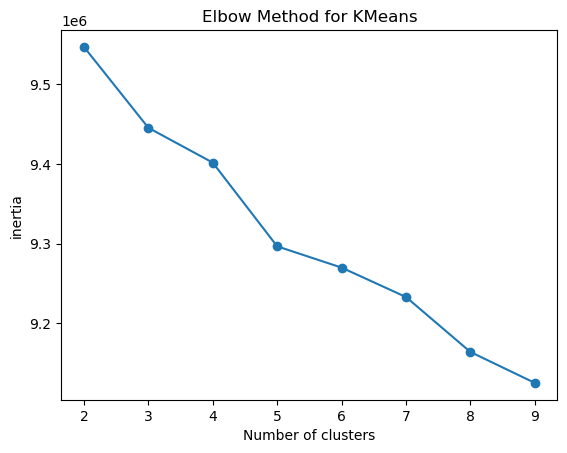

In [25]:
# finding optimal K using elbow method
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_df)

inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xticks(K)
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.title('Elbow Method for KMeans')
plt.show()


In [26]:
k =  5 # 5 is better than 4 

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

tft_match['cluster'] = clusters

cluster_summary = (
    tft_match.groupby('cluster')['placement']
    .agg(
        avg_placement='mean',
        top4_rate=lambda x: (x <= 4).mean(),
        win_rate=lambda x: (x == 1).mean(),
        games='count'
    )
    .sort_values('avg_placement')
)

cluster_summary


,avg_placement,top4_rate,win_rate,games
cluster,,,,
1,4.227454,0.551331,0.145754,10257
2,4.307121,0.537890,0.164890,5252
3,4.626620,0.480443,0.111757,8948
0,4.661781,0.469673,0.109132,8870
4,4.685898,0.457815,0.100554,6673


## Cluster distribution plot

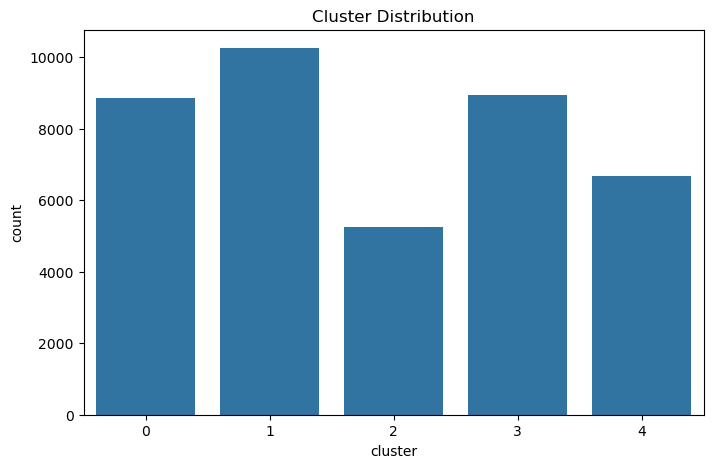

In [27]:

# plot cluster distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=tft_match)
plt.title('Cluster Distribution')
plt.show()

## PCA cluster plot 

In [28]:
# PCA to understand variance explained by components
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(X_scaled)
features = range(pca.n_components_)
expalined_variance = pca.explained_variance_ratio_
expalined_variance[:10]
expalined_variance.cumsum()[:10]

array([0.01908611, 0.03529334, 0.05047689, 0.06206375, 0.0730632 ,
       0.08261197, 0.09084822, 0.09834879, 0.10534732, 0.112217  ])

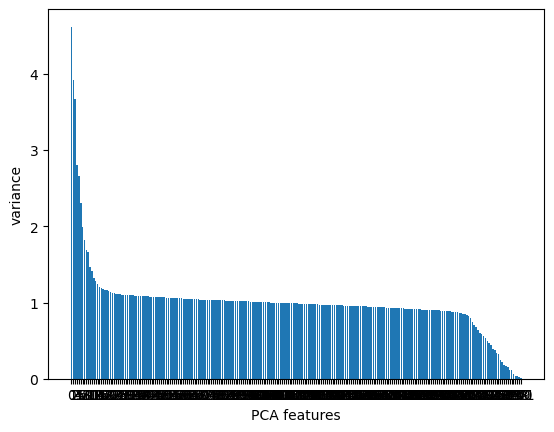

In [29]:
# plot the explained variance by PCA feature 
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA features')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

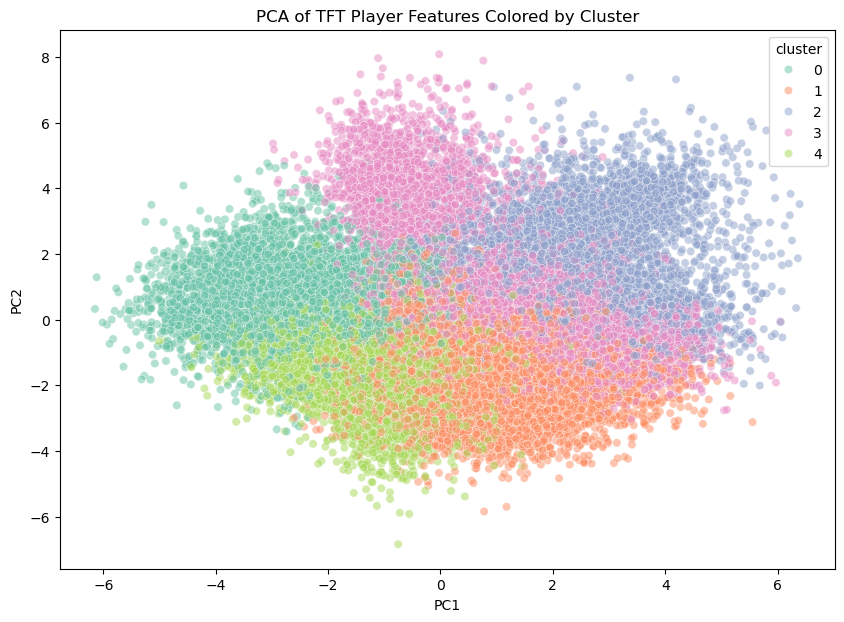

In [30]:
# PCA cluster plot 
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'],
                      index=tft_match.index)
pca_df['cluster'] = tft_match['cluster']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Set2',alpha=0.5)
plt.title('PCA of TFT Player Features Colored by Cluster')
plt.show()

## avg placement, top4, win rate of clusters

In [31]:
cluster_info=(
    tft_match
    .groupby('cluster')['placement']
    .agg(avg_placement = 'mean', top4_rate=top4_rate, win_rate=win_rate, game_counts='count')
    .sort_values('top4_rate', ascending=False)
)
cluster_info['cluster_play_rate']=cluster_info['game_counts']/cluster_info['game_counts'].sum()
cluster_info.to_csv('cluster_info.csv')

In [66]:
cluster_dis = tft_match[['cluster','placement']]
cluster_dis.to_csv('cluster_dis.csv',index=False)

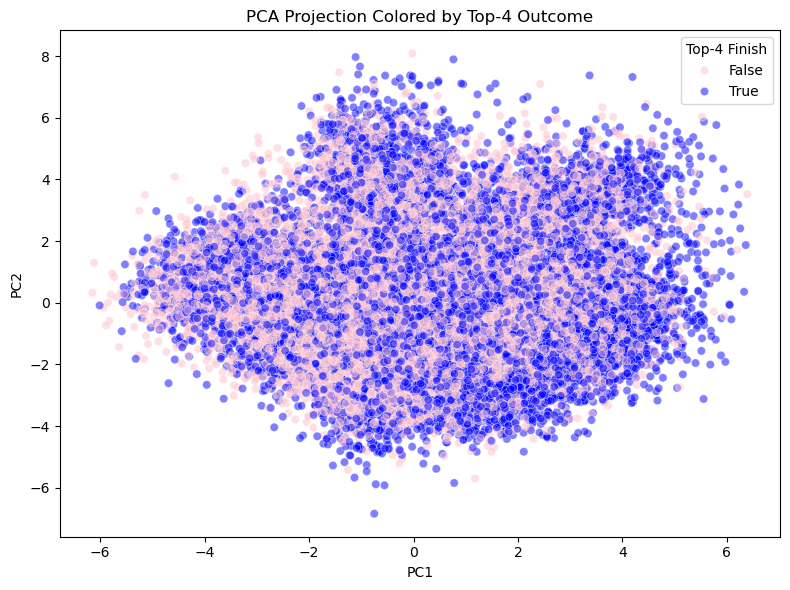

In [32]:
pca_df['top4'] = (tft_match['placement'] <= 4)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='top4',
    palette={True: 'blue', False: 'pink'},
    alpha=0.5
)

plt.title('PCA Projection Colored by Top-4 Outcome')
plt.legend(title='Top-4 Finish')
plt.tight_layout()
plt.show()


# 5. Cluster analysis

## 5.1 Trait usage by cluster 

In [33]:
cluster_trait_usage = pd.concat(
    [tft_match['cluster'], trait_matrix],
    axis=1
).groupby('cluster').mean()

cluster_trait_usage


,Arcanist,Assassin,Bodyguard,Bruiser,Challenger,Chemtech,Clockwork,Colossus,Debonair,Enchanter,...,Scholar,Scrap,Sniper,Socialite,Striker,Syndicate,Transformer,Twinshot,Yordle,YordleLord
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.658737,0.490981,2.172379,0.158512,0.862345,0.261556,1.369109,0.073844,2.406990,1.083991,...,1.210372,0.698309,1.222322,0.314318,0.071139,2.024239,0.126156,0.130891,0.152762,0.000000
1,0.114751,1.139417,0.921712,0.579409,0.243054,0.526177,0.972117,0.078483,0.144779,0.681388,...,0.250756,2.710832,0.222775,1.608658,2.140587,0.421761,0.428975,0.417568,0.605928,0.000097
2,0.590442,0.240099,0.235149,3.698781,0.392993,1.455636,0.398515,0.067212,0.219155,0.273800,...,1.004189,0.540937,0.565880,0.359482,1.181074,0.262757,0.361577,0.501714,0.262376,0.000000
3,0.659244,0.546889,0.224709,1.606983,1.525403,1.342099,0.522829,0.630148,0.218554,0.212399,...,0.569494,0.377910,0.095009,0.292525,1.283236,0.222471,0.090309,0.410586,0.166853,0.000000
4,4.130376,0.045257,0.707778,0.115990,0.047055,0.468005,0.236325,0.030421,0.338079,1.194815,...,0.536940,1.133523,0.039562,0.621909,0.272291,1.452120,0.033268,1.261202,2.406714,0.018732


### Heatmap of trait usage by cluster

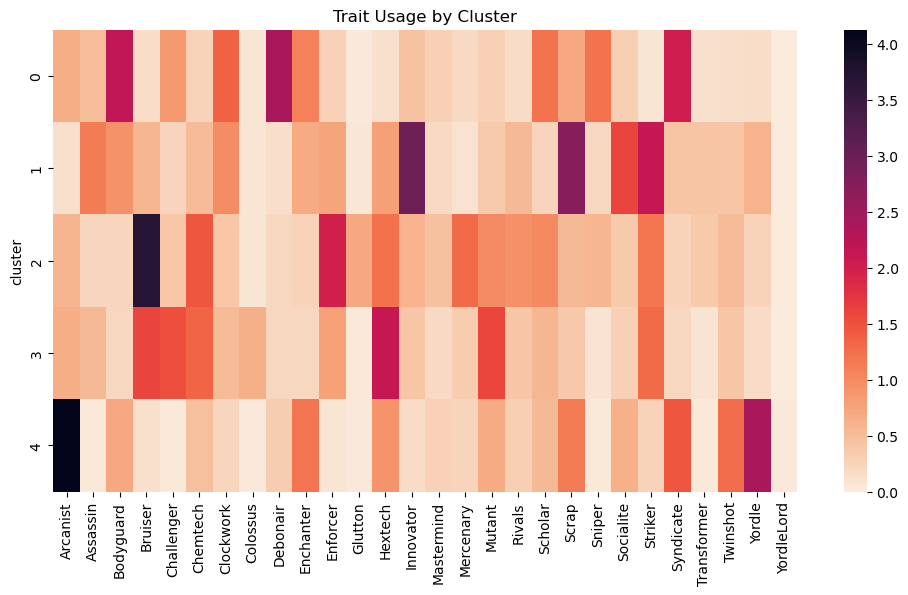

In [34]:
# plot heatmap of trait usage by cluster
plt.figure(figsize=(12,6))
sns.heatmap(cluster_trait_usage, cmap='rocket_r')
plt.title('Trait Usage by Cluster')
plt.show()


- Cluster0: Bodyguard, Clockwork, Debonair, Syndicate 
- Cluster1: Innovator, Scrap, Socialite, Striker
- Cluster2: Bruiser, Chemtech, Enforcer, Hextech
- Cluster3: Bruiser, Hextech, Mutant, Striker
- Cluster4: Arcanist, Yordle, Syndicate, Twinshot 

In [35]:
df_long = cluster_trait_usage.reset_index().melt(
    id_vars="cluster",
    var_name="trait",
    value_name="value"
)

trait_order = (
    df_long
    .groupby("trait")["value"]
    .mean()
    .sort_values(ascending=False)
    .index
)

df_long["trait"] = pd.Categorical(
    df_long["trait"],
    categories=trait_order,
    ordered=True
)


df_long.to_csv(
    "cluster_trait_heatmap.csv", index=False
)


In [191]:
# trait play rate/ cluster 
trait_cluster = traits_expanded.merge(
    tft_match[['cluster','Match ID']],
    on='Match ID',
    how='left'
)

df = trait_cluster.copy()

df["trait_active"] = df["trait_style"].astype(int) > 0

# one row per (match, cluster, trait): whether it appeared at any active level
trait_presence = (
    df[df["trait_active"]]
    .drop_duplicates(subset=["Match ID", "cluster", "trait_name"])
    .assign(present=1)
)

In [192]:
# denominator: total games in each cluster
games_in_cluster = (
    df[["Match ID", "cluster"]]
    .drop_duplicates()
    .groupby("cluster", as_index=False)
    .agg(games_in_cluster=("Match ID", "count"))
)

# numerator: games where trait is active in that cluster
trait_games = (
    trait_presence
    .groupby(["cluster", "trait_name"], as_index=False)
    .agg(games_with_trait=("Match ID", "nunique"))
)

cluster_trait = trait_games.merge(games_in_cluster, on="cluster", how="left")
cluster_trait["play_rate"] = cluster_trait["games_with_trait"] / cluster_trait["games_in_cluster"]


In [194]:
cluster_trait.to_csv('cluster_trait.csv')

In [212]:
cluster_trait.head(50)

,cluster,trait_name,games_with_trait,games_in_cluster,play_rate
0,0,Arcanist,4035,4421,0.912689
1,0,Assassin,2935,4421,0.663877
2,0,Bodyguard,4387,4421,0.992309
3,0,Bruiser,4179,4421,0.945261
4,0,Challenger,3638,4421,0.822891
5,0,Chemtech,3110,4421,0.703461
6,0,Clockwork,4230,4421,0.956797
7,0,Colossus,740,4421,0.167383
8,0,Debonair,3483,4421,0.787831
9,0,Enchanter,3589,4421,0.811807


In [217]:
trait_level_perf= trait_level_perf.merge(
    cluster_trait[['cluster','trait_name','play_rate']],
    on='trait_name',
    how='left'
).reset_index(drop=True)


In [218]:
trait_level_perf['stack_value']= (
    trait_level_perf['level_freq']
    * trait_level_perf['play_rate']
)
trait_level_perf.to_csv('trait_level_perf.csv')

In [219]:
trait_level_perf.head(50)

,trait_name,trait_style,avg_placement,top4_rate,win_rate,games,level_freq,cluster,play_rate,stack_value
0,Arcanist,1,4.348092,0.530677,0.146110,4743,0.495404,0,0.912689,0.452150
1,Arcanist,1,4.348092,0.530677,0.146110,4743,0.495404,1,0.911532,0.451577
2,Arcanist,1,4.348092,0.530677,0.146110,4743,0.495404,2,0.905879,0.448776
3,Arcanist,1,4.348092,0.530677,0.146110,4743,0.495404,3,0.916319,0.453948
4,Arcanist,1,4.348092,0.530677,0.146110,4743,0.495404,4,0.964541,0.477838
5,Arcanist,2,4.835796,0.423645,0.083744,1827,0.190829,0,0.912689,0.174168
6,Arcanist,2,4.835796,0.423645,0.083744,1827,0.190829,1,0.911532,0.173947
7,Arcanist,2,4.835796,0.423645,0.083744,1827,0.190829,2,0.905879,0.172868
8,Arcanist,2,4.835796,0.423645,0.083744,1827,0.190829,3,0.916319,0.174861
9,Arcanist,2,4.835796,0.423645,0.083744,1827,0.190829,4,0.964541,0.184063


## 5.2 Augment usage by cluster 

In [36]:
aug_expanded = (
    tft_match[['Match ID', 'placement', 'augments']]
    .reset_index()                      # original index → 'index'
    .rename(columns={'index': 'player_idx'})
    .explode('augments')
    .dropna(subset=['augments'])
    .reset_index(drop=True)
)
aug_expanded['augment_name'] = aug_expanded['augments'].map(augment_names)
aug_expanded['augment_tier'] = aug_expanded['augments'].map(augment_tier)

aug_expanded

,player_idx,Match ID,placement,augments,augment_name,augment_tier
0,0,NA1_4247681350,8,DebonairTrait,Debonair Heart,Silver
1,0,NA1_4247681350,8,Distancing2,Exiles 2,Gold
2,0,NA1_4247681350,8,DebonairEmblem2,Debonair Crown,Prismatic
3,1,NA1_4247681350,3,AssassinCutthroat,Cutthroat,Silver
4,1,NA1_4247681350,3,RichGetRicher,Rich Get Richer,Gold
...,...,...,...,...,...,...
118829,39998,NA1_4255593521,7,Weakspot,Weakspot 1,Silver
118830,39998,NA1_4255593521,7,Archangel2,Archangel's Embrace,Gold
118831,39999,NA1_4255593521,8,Underdogs,Underdogs,Silver
118832,39999,NA1_4255593521,8,ScholarTrait,Scholar Heart,Silver


In [37]:
def strip_tier(name):
    if pd.isna(name):
        return None
    return name.replace(' 1', '').replace(' 2', '').replace(' 3', '')

aug_expanded['augment_base'] = aug_expanded['augment_name'].apply(strip_tier)
aug_expanded

,player_idx,Match ID,placement,augments,augment_name,augment_tier,augment_base
0,0,NA1_4247681350,8,DebonairTrait,Debonair Heart,Silver,Debonair Heart
1,0,NA1_4247681350,8,Distancing2,Exiles 2,Gold,Exiles
2,0,NA1_4247681350,8,DebonairEmblem2,Debonair Crown,Prismatic,Debonair Crown
3,1,NA1_4247681350,3,AssassinCutthroat,Cutthroat,Silver,Cutthroat
4,1,NA1_4247681350,3,RichGetRicher,Rich Get Richer,Gold,Rich Get Richer
...,...,...,...,...,...,...,...
118829,39998,NA1_4255593521,7,Weakspot,Weakspot 1,Silver,Weakspot
118830,39998,NA1_4255593521,7,Archangel2,Archangel's Embrace,Gold,Archangel's Embrace
118831,39999,NA1_4255593521,8,Underdogs,Underdogs,Silver,Underdogs
118832,39999,NA1_4255593521,8,ScholarTrait,Scholar Heart,Silver,Scholar Heart


In [38]:
augment_strength = (
    aug_expanded
    .merge(tft_match[['cluster']], left_on='player_idx', right_index=True)
    .groupby(['cluster', 'augment_base','augment_tier'])['placement']
    .agg(
        top4_rate=lambda x: (x <= 4).mean(),
        win_rate=lambda x: (x == 1).mean(),
        games='count'
    )
    .reset_index()
)

# filter unreliable augments
augment_strength = augment_strength[augment_strength['games'] >= 100]


### Top4 rate of single augment per cluster 

In [39]:
top_augments_by_cluster = (
    augment_strength
    .sort_values(['cluster', 'top4_rate'], ascending=[True, False])
    .groupby('cluster')
    .head(10)
)
top_augments_by_cluster 

,cluster,augment_base,augment_tier,top4_rate,win_rate,games
58,0,Debonair Crown,Prismatic,0.567568,0.144144,111
165,0,Stand Behind Me,Silver,0.563953,0.180233,172
167,0,Stand United,Prismatic,0.559633,0.137615,109
77,0,Exiles,Silver,0.555556,0.120370,108
99,0,Irresistible Charm,Gold,0.549587,0.157025,242
32,0,Celestial Blessing,Prismatic,0.537415,0.136054,147
21,0,Bodyguard Crown,Prismatic,0.536000,0.136000,125
75,0,Exiles,Gold,0.533835,0.127820,133
113,0,Ludens Echo,Silver,0.532374,0.136691,417
60,0,Disintegrator,Gold,0.531250,0.101562,256


### Top4 rate of single augment category (Econ, Combat, Utility) per cluster 

In [40]:
# common augment categories 
augment_category = {
    'AFK': 'Econ',
    'Rich Get Richer': 'Econ',
    'Trade Sector': 'Econ',
    'Windfall': 'Econ',
    'Hustler': 'Econ',

    'Celestial Blessing': 'Combat',
    'Second Wind': 'Combat',
    'Thrill of the Hunt': 'Combat',
    'Stand United': 'Combat',
    'Exiles': 'Combat',

    'Pandoras Items': 'Utility',
    'Component Grab Bag': 'Utility',
    'Portable Forge': 'Utility',
    'Binary Airdrop': 'Utility'
}

aug_expanded['augment_type'] = aug_expanded['augment_base'].map(augment_category)

aug_expanded = aug_expanded.dropna(subset=['augment_type'])
aug_expanded 

,player_idx,Match ID,placement,augments,augment_name,augment_tier,augment_base,augment_type
1,0,NA1_4247681350,8,Distancing2,Exiles 2,Gold,Exiles,Combat
4,1,NA1_4247681350,3,RichGetRicher,Rich Get Richer,Gold,Rich Get Richer,Econ
5,1,NA1_4247681350,3,Diversify3,Stand United 3,Prismatic,Stand United,Combat
16,5,NA1_4247681350,6,ComponentGrabBag,Component Grab Bag,Gold,Component Grab Bag,Utility
21,7,NA1_4247681350,5,ThrillOfTheHunt1,Thrill of the Hunt 1,Silver,Thrill of the Hunt,Combat
...,...,...,...,...,...,...,...,...
118804,39990,NA1_4273913449,3,Distancing,Exiles 1,Silver,Exiles,Combat
118815,39993,NA1_4255593521,5,Distancing2,Exiles 2,Gold,Exiles,Combat
118816,39994,NA1_4255593521,2,SecondWind1,Second Wind 1,Silver,Second Wind,Combat
118826,39997,NA1_4255593521,4,ThrillOfTheHunt1,Thrill of the Hunt 1,Silver,Thrill of the Hunt,Combat


In [41]:
# the conditional probability of a top-4 finish given that the augment was selected
# without adjusting for other covariates.
augment_type_perf = (
    aug_expanded
    .merge(tft_match[['cluster']], left_on='player_idx', right_index=True)
    .groupby(['cluster', 'augment_type','augment_tier'])['placement']
    .agg(
        top4_rate=lambda x: (x <= 4).mean(),
        avg_placement='mean',
        games='count'
    )
    .reset_index()
)
augment_type_perf

,cluster,augment_type,augment_tier,top4_rate,avg_placement,games
0,0,Combat,Gold,0.474587,4.609920,1633
1,0,Combat,Prismatic,0.530822,4.404110,292
2,0,Combat,Silver,0.446165,4.788881,1421
3,0,Econ,Gold,0.430147,4.944853,272
4,0,Econ,Prismatic,0.265306,5.387755,98
5,0,Utility,Gold,0.491333,4.518231,1673
6,1,Combat,Gold,0.542094,4.262320,1948
7,1,Combat,Prismatic,0.602015,3.992443,397
8,1,Combat,Silver,0.552987,4.222864,1557
9,1,Econ,Gold,0.488746,4.559486,311


### Pair-wise augment analysis per cluster by top4 rate

In [42]:
from itertools import combinations

pair_rows = []

for pid, group in aug_expanded.groupby('player_idx'):
    aug_list = group['augment_base'].unique()
    placement = tft_match.loc[pid, 'placement']
    cluster = tft_match.loc[pid, 'cluster']

    for a, b in combinations(sorted(aug_list), 2):
        pair_rows.append({
            'cluster': cluster,
            'augment_a': a,
            'augment_b': b,
            'placement': placement
        })

augment_pairs = pd.DataFrame(pair_rows)


In [43]:
pair_perf = (
    augment_pairs
    .groupby(['cluster', 'augment_a', 'augment_b'])['placement']
    .agg(
        top4_rate=lambda x: (x <= 4).mean(),
        games='count'
    )
    .reset_index()
)
pair_perf = pair_perf[pair_perf['games'] >= 30]


In [44]:
top_pairs_by_cluster = (
    pair_perf
    .sort_values(['cluster', 'top4_rate'], ascending=[True, False])
    .groupby('cluster')
    .head(10)
)
top_pairs_by_cluster

,cluster,augment_a,augment_b,top4_rate,games
43,0,Second Wind,Stand United,0.548387,31
35,0,Portable Forge,Stand United,0.547619,42
15,0,Celestial Blessing,Stand United,0.518519,54
10,0,Celestial Blessing,Component Grab Bag,0.500000,62
34,0,Portable Forge,Second Wind,0.500000,30
12,0,Celestial Blessing,Portable Forge,0.459016,61
47,0,Stand United,Thrill of the Hunt,0.448980,49
36,0,Portable Forge,Thrill of the Hunt,0.419355,31
23,0,Component Grab Bag,Thrill of the Hunt,0.384615,52
44,0,Second Wind,Thrill of the Hunt,0.323529,34


## 5.3 Top-10 champions by cluster

In [91]:

units_expanded = (
    tft_match[['units', 'placement']]
    .reset_index()                      # original index → 'index'
    .rename(columns={'index': 'player_idx'})
    .explode('units')
    .dropna(subset=['units'])
    .reset_index(drop=True)
)

units_expanded['champ_name'] = units_expanded['units'].apply(lambda u: u.get('character_id'))
units_expanded['tier'] = units_expanded['units'].apply(lambda u: u.get('tier'))
units_expanded['rarity'] = units_expanded['units'].apply(lambda u: u.get('rarity'))
units_expanded['items'] = units_expanded['units'].apply(lambda u: u.get('items', []))

In [92]:
# Add cluster label to unit rows
units_expanded = units_expanded.merge(
    tft_match[['cluster']],
    left_on='player_idx',
    right_index=True,
    how='left'
)

champ_usage_by_cluster = (
    units_expanded.groupby(['cluster', 'champ_name'])
    .size()
    .reset_index(name='count')
)
# Normalize counts so it's 'frequency within cluster'
cluster_sizes = tft_match['cluster'].value_counts().to_dict()

champ_usage_by_cluster['freq'] = champ_usage_by_cluster.apply(
    lambda row: row['count'] / cluster_sizes[row['cluster']],
    axis=1
)


In [93]:
units_expanded 

,player_idx,units,placement,champ_name,tier,rarity,items,cluster
0,0,"{'character_id': 'Talon', 'items': [69, 19, 22...",8,Talon,2,1,"[69, 19, 22]",0
1,0,"{'character_id': 'Zyra', 'items': [70], 'name'...",8,Zyra,2,1,[70],0
2,0,"{'character_id': 'Blitzcrank', 'items': [70], ...",8,Blitzcrank,2,1,[70],0
3,0,"{'character_id': 'Syndra', 'items': [], 'name'...",8,Syndra,2,1,[],0
4,0,"{'character_id': 'Leona', 'items': [], 'name':...",8,Leona,1,2,[],0
...,...,...,...,...,...,...,...,...
318945,39999,"{'character_id': 'RekSai', 'items': [], 'name'...",8,RekSai,2,1,[],3
318946,39999,"{'character_id': 'Malzahar', 'items': [37, 44,...",8,Malzahar,3,2,"[37, 44, 22]",3
318947,39999,"{'character_id': 'ChoGath', 'items': [57, 6, 4...",8,ChoGath,3,2,"[57, 6, 47]",3
318948,39999,"{'character_id': 'Alistar', 'items': [26], 'na...",8,Alistar,2,3,[26],3


In [148]:
# top 10 champs per cluster
top_n = 10

top_champs_per_cluster = (
    champ_usage_by_cluster
    .sort_values(['cluster', 'freq'], ascending=[True, False])
    .groupby('cluster')
    .head(top_n)
)

top_champs_per_cluster


,cluster,champ_name,count,freq
5,0,Braum,6713,0.756821
26,0,Leona,6080,0.685457
33,0,Orianna,5108,0.575874
21,0,Jhin,4150,0.467869
45,0,Syndra,3706,0.417813
11,0,Draven,3511,0.395829
55,0,Zeri,3435,0.387260
3,0,Blitzcrank,3171,0.357497
58,0,Zyra,3101,0.349605
31,0,Morgana,3056,0.344532


In [114]:
unit_info = top_champs_per_cluster.merge(
    units_expanded[['cluster','champ_name','tier','items']],
    on=['cluster','champ_name'],
    how='left'
)
unit_info

,cluster,champ_name,count,freq,tier,items
0,0,Braum,6713,0.756821,2,"[70, 5]"
1,0,Braum,6713,0.756821,2,[]
2,0,Braum,6713,0.756821,2,[77]
3,0,Braum,6713,0.756821,2,[4]
4,0,Braum,6713,0.756821,1,[45]
...,...,...,...,...,...,...
180969,4,Lulu,2176,0.326090,2,[]
180970,4,Lulu,2176,0.326090,2,[35]
180971,4,Lulu,2176,0.326090,1,[]
180972,4,Lulu,2176,0.326090,2,[67]


In [115]:
unit_info['number_of_items'] = unit_info['items'].apply(len)
unit_info.to_csv('unit_info.csv')

In [149]:
top_champs_per_cluster.rename(columns={'count': 'champion_count', 'freq':'champion_pick_rate'}, inplace=True)
top_champs_per_cluster["champ_rank_in_cluster"] = (
    top_champs_per_cluster.sort_values(["cluster", "champion_pick_rate"], ascending=[True, False])
      .groupby("cluster")
      .cumcount() + 1
)

top_champs_per_cluster["side"] = None

top_champs_per_cluster.loc[top_champs_per_cluster["champ_rank_in_cluster"] <= 5, "side"] = "Core"
top_champs_per_cluster.loc[top_champs_per_cluster["champ_rank_in_cluster"] > top_champs_per_cluster.groupby("cluster")["champ_rank_in_cluster"].transform("max") - 5, "side"] = "Flex"

top_champs_per_cluster = top_champs_per_cluster[top_champs_per_cluster["side"].notna()]
top_champs_per_cluster["side_rank"] = (
    top_champs_per_cluster.sort_values(["cluster", "side", "champ_rank_in_cluster"])
      .groupby(["cluster", "side"])
      .cumcount() + 1
)

top_champs_per_cluster
top_champs_per_cluster.to_csv('top_champs_per_cluster.csv')

In [151]:
# winrate and top4 rate by cluster and champ 
champ_winrate = (
    units_expanded.groupby(['cluster','champ_name'])['placement']
    .agg(avg_placement = 'mean',
         top4_rate=top4_rate, 
         win_rate=win_rate))
champ_winrate = champ_winrate.merge(
    top_champs_per_cluster,
    on=['cluster','champ_name'],
    how='right'
)
champ_winrate.to_csv('champ_winrate.csv')

In [150]:
top_champs_per_cluster

,cluster,champ_name,champion_count,champion_pick_rate,champ_rank_in_cluster,side,side_rank
5,0,Braum,6713,0.756821,1,Core,1
26,0,Leona,6080,0.685457,2,Core,2
33,0,Orianna,5108,0.575874,3,Core,3
21,0,Jhin,4150,0.467869,4,Core,4
45,0,Syndra,3706,0.417813,5,Core,5
11,0,Draven,3511,0.395829,6,Flex,1
55,0,Zeri,3435,0.387260,7,Flex,2
3,0,Blitzcrank,3171,0.357497,8,Flex,3
58,0,Zyra,3101,0.349605,9,Flex,4
31,0,Morgana,3056,0.344532,10,Flex,5


## 5.4 Item per champion per cluster 

In [50]:
items_expanded

,Match ID,placement,champ_name,item_id,item_id_str,item_name
0,NA1_4247681350,8,Talon,69,69,Quicksilver
1,NA1_4247681350,8,Talon,19,19,Infinity Edge
2,NA1_4247681350,8,Talon,22,22,Rapid Firecannon
3,NA1_4247681350,8,Zyra,70,70,Debonair Emblem
4,NA1_4247681350,8,Blitzcrank,70,70,Debonair Emblem
...,...,...,...,...,...,...
387691,NA1_4255593521,8,ChoGath,47,47,Redemption
387692,NA1_4255593521,8,Alistar,26,26,Runaan's Hurricane
387693,NA1_4255593521,8,Kaisa,23,23,Guinsoo's Rageblade
387694,NA1_4255593521,8,Kaisa,34,34,Archangel's Staff


In [51]:
units_expanded = (
    tft_match[['units', 'placement']]
    .reset_index()                          # old index → becomes 'index'
    .rename(columns={'index': 'player_idx'})  # rename it to player_idx
    .explode('units')
    .dropna(subset=['units'])
    .reset_index(drop=True)
)

units_expanded['champ_name'] = units_expanded['units'].apply(lambda u: u.get('name'))
units_expanded['champ_id']   = units_expanded['units'].apply(lambda u: u.get('character_id'))
units_expanded['tier']       = units_expanded['units'].apply(lambda u: u.get('tier'))
units_expanded['rarity']     = units_expanded['units'].apply(lambda u: u.get('rarity'))
units_expanded['items']      = units_expanded['units'].apply(lambda u: u.get('items', []))


item_rows = []

for _, row in units_expanded.iterrows():
    pid = row['player_idx']
    placement = row['placement']
    champ = row['champ_id']
    tier = row['tier']
    for item_id in row['items']:
        item_rows.append({
            'player_idx': pid,
            'placement': placement,
            'champ_name': champ,
            'champ_tier': tier,
            'item_id': item_id
        })

items_expanded = pd.DataFrame(item_rows)
items_expanded['item_id_str'] = items_expanded['item_id'].astype(str)
items_expanded['item_name'] = items_expanded['item_id_str'].map(item_dict)

items_expanded = items_expanded.merge(
    tft_match[['cluster']],
    left_on='player_idx',
    right_index=True,
    how='left'
)


item_usage = (
    items_expanded
    .groupby(['cluster', 'champ_name', 'item_name'])
    .size()
    .reset_index(name='item_count')
)

item_usage

,cluster,champ_name,item_name,item_count
0,0,Ahri,Archangel's Staff,82
1,0,Ahri,Assassin Emblem,2
2,0,Ahri,B.F. Sword,1
3,0,Ahri,Banshee's Claw,16
4,0,Ahri,Bloodthirster,3
...,...,...,...,...
13624,4,Zyra,Titan's Resolve,1
13625,4,Zyra,Warmog's Armor,1
13626,4,Zyra,Zeke's Herald,17
13627,4,Zyra,Zephyr,31


### most used item (top5) per champion per cluster 

In [52]:
# finding most used items per champion per cluster 
item_usage['item_rank_per_champ_cluster'] = (
    item_usage
    .groupby(['cluster', 'champ_name'])['item_count']
    .rank(method='first', ascending=False)
)
top_item_per_champ = item_usage[item_usage['item_rank_per_champ_cluster'] <=5 ].copy()

top_champs_with_items = top_champs_per_cluster.merge(
    top_item_per_champ[['cluster', 'champ_name', 'item_rank_per_champ_cluster','item_name', 'item_count']],
    on=['cluster', 'champ_name'],
    how='left'
)
top_champs_with_items.sort_values(['cluster','champ_rank_in_cluster','item_rank_per_champ_cluster'],ascending=True)
top_champs_with_items.to_csv('top_champs_with_items.csv', index=False)

In [53]:
for c in sorted(top_champs_with_items['cluster'].unique()):
    print(f'\n=== Cluster {c} — Top Champions & Their most used Items ===')
    sub = top_champs_with_items[top_champs_with_items['cluster'] == c]
    for _, row in sub.iterrows():
        print(f'{row['champ_name']:12} freq={row['champion_pick_rate']:.2f}   item={row['item_name']}')



=== Cluster 0 — Top Champions & Their most used Items ===
Braum        freq=0.76   item=Bramble Vest
Braum        freq=0.76   item=Frozen Heart
Braum        freq=0.76   item=Gargoyle Stoneplate
Braum        freq=0.76   item=Sunfire Cape
Braum        freq=0.76   item=Warmog's Armor
Leona        freq=0.69   item=Bramble Vest
Leona        freq=0.69   item=Gargoyle Stoneplate
Leona        freq=0.69   item=Redemption
Leona        freq=0.69   item=Sunfire Cape
Leona        freq=0.69   item=Warmog's Armor
Orianna      freq=0.58   item=Banshee's Claw
Orianna      freq=0.58   item=Chalice of Power
Orianna      freq=0.58   item=Locket of the Iron Solari
Orianna      freq=0.58   item=Spear of Shojin
Orianna      freq=0.58   item=Zeke's Herald
Jhin         freq=0.47   item=Giant Slayer
Jhin         freq=0.47   item=Infinity Edge
Jhin         freq=0.47   item=Last Whisper
Jhin         freq=0.47   item=Quicksilver
Jhin         freq=0.47   item=Runaan's Hurricane
Syndra       freq=0.42   item=Banshe

In [60]:
item_usage_cluster = (
    items_expanded
    .groupby(['cluster', 'item_name'])
    .size()
    .reset_index(name='item_count_cluster')
)


In [62]:
cluster_item_total = (
    item_usage_cluster
    .groupby('cluster')['item_count_cluster']
    .transform('sum')
)
item_usage_cluster['item_play_rate_per_cluster'] = item_usage_cluster['item_count_cluster'] / cluster_item_total
item_usage_cluster.sort_values(['cluster','item_play_rate_per_cluster'],ascending=[True,False],inplace=True)
item_usage_cluster

,cluster,item_name,item_count_cluster,item_play_rate_per_cluster
47,0,Infinity Edge,4429,0.052868
37,0,Giant Slayer,3856,0.046028
60,0,Morellonomicon,3750,0.044763
41,0,Guinsoo's Rageblade,3096,0.036956
66,0,Quicksilver,2656,0.031704
...,...,...,...,...
471,4,Fist of Fairness,1,0.000016
492,4,Luminous Deathblade,1,0.000016
509,4,Rapid Lightcannon,1,0.000016
516,4,Runaan's Tempest,1,0.000016


In [64]:
avg_place_per_item_cluster = (
    items_expanded
    .groupby(['cluster','item_name'])['placement']
    .mean()
    .reset_index(name='avg_place_when_item_used')
)
item_cluster_info = avg_place_per_item_cluster.merge(
    item_usage_cluster[['cluster','item_name','item_play_rate_per_cluster']],
    on=['cluster','item_name'],
    how='left')
item_cluster_info.groupby(['cluster','item_name'])[['avg_place_when_item_used','item_play_rate_per_cluster']]
item_cluster_info.to_csv('item_cluster_info.csv')

### best champ per item per cluster by avg placement 


In [159]:
min_games = 100 
best_champs = (
    items_expanded
    .groupby(['cluster', 'item_name','champ_name'])['placement']
    .agg(
        avg_placement='mean',
        top4_rate=lambda x: (x <= 4).mean(),
        win_rate=lambda x: (x == 1).mean(),
        games='count'
    )
    .reset_index()
    .sort_values(['cluster', 'avg_placement'], ascending=[True, True])
)
best_champs = best_champs[best_champs.games >= min_games]


In [162]:
best_champs

,cluster,item_name,champ_name,avg_placement,top4_rate,win_rate,games
1418,0,Last Whisper,Zeri,3.232877,0.739726,0.294521,146
1818,0,Rabadon's Deathcap,Viktor,3.350365,0.708029,0.262774,137
782,0,Edge of Night,Jinx,3.455285,0.682927,0.219512,123
2359,0,Spear of Shojin,Viktor,3.523333,0.693333,0.203333,300
2705,0,Titan's Resolve,Zeri,3.536000,0.696000,0.176000,125
...,...,...,...,...,...,...,...
13424,4,Titan's Resolve,Gangplank,4.959276,0.393665,0.104072,221
11657,4,Blue Buff,Corki,4.984095,0.405567,0.091451,503
12291,4,Hextech Gunblade,Corki,4.986607,0.392857,0.080357,224
12208,4,Guinsoo's Rageblade,Senna,5.009434,0.386792,0.056604,106


In [161]:
best_champs.to_csv('best_champs.csv')

### best items per champ per cluster by top4 rate 

In [56]:
items_expanded

,player_idx,placement,champ_name,champ_tier,item_id,item_id_str,item_name,cluster
0,0,8,Talon,2,69,69,Quicksilver,0
1,0,8,Talon,2,19,19,Infinity Edge,0
2,0,8,Talon,2,22,22,Rapid Firecannon,0
3,0,8,Zyra,2,70,70,Debonair Emblem,0
4,0,8,Blitzcrank,2,70,70,Debonair Emblem,0
...,...,...,...,...,...,...,...,...
387691,39999,8,ChoGath,3,47,47,Redemption,3
387692,39999,8,Alistar,2,26,26,Runaan's Hurricane,3
387693,39999,8,Kaisa,1,23,23,Guinsoo's Rageblade,3
387694,39999,8,Kaisa,1,34,34,Archangel's Staff,3


In [57]:
item_strength = (
    items_expanded
    .groupby(['cluster', 'champ_name', 'item_name'])['placement']
    .agg(
        avg_placement='mean',
        top4_rate=lambda x: (x <= 4).mean(),
        win_rate=lambda x: (x == 1).mean(),
        games='count'
    )
    .reset_index()
)
item_strength


,cluster,champ_name,item_name,avg_placement,top4_rate,win_rate,games
0,0,Ahri,Archangel's Staff,4.414634,0.524390,0.097561,82
1,0,Ahri,Assassin Emblem,1.500000,1.000000,0.500000,2
2,0,Ahri,B.F. Sword,6.000000,0.000000,0.000000,1
3,0,Ahri,Banshee's Claw,5.312500,0.312500,0.000000,16
4,0,Ahri,Bloodthirster,2.666667,1.000000,0.333333,3
...,...,...,...,...,...,...,...
13624,4,Zyra,Titan's Resolve,3.000000,1.000000,0.000000,1
13625,4,Zyra,Warmog's Armor,6.000000,0.000000,0.000000,1
13626,4,Zyra,Zeke's Herald,3.764706,0.647059,0.176471,17
13627,4,Zyra,Zephyr,4.419355,0.516129,0.096774,31


In [58]:
# best items per champ per cluster by top4 rate 

min_games = 20   # or 10, depending on dataset size

item_strength_filtered = item_strength[item_strength['games'] >= min_games]

best_item_by_top4 = (
    item_strength_filtered
    .sort_values(['cluster', 'champ_name', 'top4_rate'], ascending=[True, True, False])
    .groupby(['cluster', 'champ_name'])
    .head(1)
    .reset_index(drop=True)
)
best_item_by_top4




,cluster,champ_name,item_name,avg_placement,top4_rate,win_rate,games
0,0,Ahri,Debonair Emblem,4.107692,0.553846,0.153846,65
1,0,Alistar,Gargoyle Stoneplate,4.148148,0.592593,0.074074,27
2,0,Ashe,Rapid Firecannon,4.000000,0.594595,0.243243,37
3,0,Blitzcrank,Banshee's Claw,3.476190,0.809524,0.142857,21
4,0,Brand,Infinity Edge,4.720930,0.534884,0.046512,43
...,...,...,...,...,...,...,...
192,4,Vi,Ionic Spark,4.380952,0.619048,0.047619,21
193,4,Viktor,Redemption,3.565217,0.739130,0.173913,23
194,4,Zeri,Arcanist Emblem,5.142857,0.333333,0.047619,21
195,4,Ziggs,Zz'Rot Portal,3.500000,0.714286,0.178571,28


### top-10 champions per cluster with best items by top4 rate

In [59]:
# merge with top 10 champs per cluster
top_champs_with_best_items = top_champs_per_cluster.merge(
    best_item_by_top4[['cluster', 'champ_name', 'item_name', 'top4_rate','avg_placement']],
    on=['cluster', 'champ_name'],
    how='left'
)
top_champs_with_best_items

,cluster,champ_name,champion_count,champion_pick_rate,champ_rank_in_cluster,side,side_rank,item_name,top4_rate,avg_placement
0,0,Braum,6713,0.756821,1,Core,1,Banshee's Claw,0.733333,3.488889
1,0,Leona,6080,0.685457,2,Core,2,Banshee's Claw,0.744681,3.638298
2,0,Orianna,5108,0.575874,3,Core,3,Redemption,0.804878,3.219512
3,0,Jhin,4150,0.467869,4,Core,4,Locket of the Iron Solari,0.727273,3.606061
4,0,Syndra,3706,0.417813,5,Core,5,Assassin Emblem,0.662162,3.878378
5,0,Draven,3511,0.395829,6,Flex,1,Assassin Emblem,0.745455,3.781818
6,0,Zeri,3435,0.387260,7,Flex,2,Rapid Firecannon,0.766667,3.383333
7,0,Blitzcrank,3171,0.357497,8,Flex,3,Banshee's Claw,0.809524,3.476190
8,0,Zyra,3101,0.349605,9,Flex,4,Hand Of Justice,0.821429,3.642857
9,0,Morgana,3056,0.344532,10,Flex,5,Debonair Emblem,0.723404,3.382979
